# Portfolio Stress Testing with Deep Generative Models

**This code currently is still under development, so for now the results are not the conclusions.**

## Table of Contents

0. [Abstract](#section_0)

1. [Global Variables](#section_1)

2. [Imports and Settings](#section_2)

3. [GPU Configuration](#section_3)

4. [Data Collection and Preprocessing](#section_4)
    - [4.0 Parameters](#section_4_0)
    - [4.1 Portfolio Selection](#section_4_1)
    - [4.2 Download Market Data](#section_4_2)
    - [4.3 Preprocess Market Data](#section_4_3)
    - [4.4 Download and Prepare Macroeconomic Indicators](#section_4_4)
    - [4.5 Prepare Input Features](#section_4_5)

5. [Model Implementation](#section_5)
    - [5.1 Define Custom Layers](#section_5_1)
    - [5.2 Conditional Variational Autoencoder (cVAE)](#section_5_2)
    - [5.3 Conditional Wasserstein GAN (WGAN-GP)](#section_5_3)

6. [Model Training](#section_6)
    - [6.1 Training Parameters](#section_6_1)
    - [6.2 Train Conditional VAE](#section_6_2)
    - [6.3 Train Conditional WGAN-GP](#section_6_3)
    - [6.4 Plot Training Losses](#section_6_4)
    - [6.5 Save & Load Models](#section_6_5)

7. [Scenario Generation and Stress Testing](#section_7)
    - [7.1 Feature Sensitivity Analysis](#section_7_1)
    - [7.2 Backtesting Scenario Creation](#section_7_2)
    - [7.3 Rolling Backtesting](#section_7_3)
    - [7.4 Backtesting Analysis by Stock](#section_7_4)
    - [7.5 Daily Backtesting](#section_7_5)

<a id="section_0"></a>
## Abstract

Financial markets exhibit extreme volatility that often renders traditional risk models insufficient, as these models typically rely on historical data and oversimplified assumptions. This project presents a robust portfolio stress-testing framework based on deep generative models, specifically, a Conditional Variational Autoencoder (cVAE) and a Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP). By conditioning on key macroeconomic indicators such as inflation, interest rates, volatility, and exchange rates, the models generate realistic synthetic return scenarios that capture the complex, nonlinear dependencies between assets during periods of market stress. Applied to a refined selection of Warren Buffett’s Q4 2019 holdings, the framework enables the estimation of critical risk measures, including Value at Risk (VaR) and Expected Shortfall (ES). Additional metrics, such as Earth Mover’s Distance, Jensen-Shannon Divergence, and the Kolmogorov-Smirnov test, are used to validate the fidelity of the generated scenarios against historical data. Moreover, latent space clustering is employed to classify distinct stress regimes, potentially flagging black swan events. The modular design, which encompasses data acquisition, preprocessing, model training, scenario generation, and risk evaluation, provides a flexible and powerful tool for both academic research and practical risk management applications.

<a id="section_1"></a>
## Global Variables

In [2]:
SEED_RANDOM = 101

EPOCHS_WGAN = 1000
EPOCHS_CVAE = 500
LATENT_DIM = 8
NOISE_DIM = 10
WGANGP_PATIENCE = 400

NUM_SCENARIOS = 10000

LOAD_MODEL = False
LOGGING_ENABLED = True
USE_GPU = True

FOLDER_MODELS = "models"

START_DATE = "2004-01-01"
START_BACKTEST = "2020-02-20"
END_BACKTEST = "2020-05-01"
END_DATE = "2021-01-01"

<a id="section_2"></a>
## Imports and Settings

In [3]:
import os

import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import logging
import warnings

2025-03-12 23:36:45.370648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 23:36:45.402282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 23:36:45.993510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
from custom_libraries.start_gpu import gpu_available
from custom_libraries.download_data import (
    download_market_data,
    download_fred_data,
    download_other_data,
)
from custom_libraries.preprocess_data import (
    preprocess_market_data,
    preprocess_macro_data,
    process_input_features,
)
from custom_libraries.utils_plot import (
    plot_missing_values,
    plot_correlation_matrix,
    plot_stock_returns,
    plot_macro_trend,
    plot_gan_losses,
    plot_historical_vs_synthetic_var_period,
    plot_mean_grad_features,
    plot_historical_vs_synthetic_var_period_per_tickers,
)
from custom_libraries.utils import (
    save_models,
    load_models,
)
from custom_libraries.stress_backtesting import (
    rolling_backtest,
    detailed_evaluation_forecast,
    backtest_tickers_ret_syn,
)
from custom_libraries.utils_plot import (
    plot_bar_diff,
    plot_scatter_actual_vs_synthetic_oblique,
    plot_latent_space_clustering,
    plot_distribution_synthetic_portfolio,
)

In [6]:
if LOGGING_ENABLED:
    logging.basicConfig(filename="debug.log", level=logging.INFO)
else:
    logging.basicConfig(level=logging.CRITICAL)

<a id="section_3"></a>
## GPU Configuration

In [7]:
gpu_available(USE_GPU)

Number of GPUs Available: 1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory limited to 8GB (8192MB)


<a id="section_4"></a>
## Data Collection and Preprocessing

<a id="section_4_0"></a>
### Parameters

In [8]:
np.random.seed(SEED_RANDOM)
random.seed(SEED_RANDOM)
tf.random.set_seed(SEED_RANDOM)

start_date = START_DATE
backtest_start = START_BACKTEST
backtest_end = END_BACKTEST
end_date = END_DATE

# To allow forward fill, download macro data starting 1 year earlier
pre_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime(
    "%Y-%m-%d"
)

<a id="section_4_1"></a>
### Portfolio Selection

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [9]:
portfolio_df = pd.read_csv("portfolio.csv")
tickers = portfolio_df["ticker"].tolist()

portfolio_df["weight"] = portfolio_df["weight"] / 100.0
portfolio_weights = portfolio_df["weight"].values

<a id="section_4_2"></a>
### Download Market Data

In [10]:
market_data = download_market_data(tickers, pre_start_date, end_date)
market_data.head()

YF.download() has changed argument auto_adjust default to True


Price          Close                                                      \
Ticker          AAPL    AMZN        AXP        BAC       BIIB         BK   
Date                                                                       
2003-01-02  0.222693  0.9785  23.394018  20.762495  34.340000  15.763545   
2003-01-03  0.224197  1.0260  23.476961  20.633244  33.689999  15.869803   
2003-01-06  0.224197  1.0350  24.299931  20.929928  34.230000  16.663605   
2003-01-07  0.223445  1.0775  23.974562  20.962246  34.240002  16.588600   
2003-01-08  0.218931  1.0510  23.795938  20.877052  33.029999  15.938556   

Price                                                  ...   Volume          \
Ticker           COST       DVA         GL         GS  ...      PNC    SIRI   
Date                                                   ...                    
2003-01-02  19.460583  8.363333  13.479929  50.043800  ...   792500  225260   
2003-01-03  18.950766  8.460000  13.487144  50.568317  ...  1109100  117150   
2003-01-06  19.178848  8.483333  13.703861  52.450802  ...  1756200  162380   
2003-01-07  19.487421  8.416667  13.544928  52.235233  ...  1597900  641390   
2003-01-08  19.655132  8.376667  13.508814  50.956295  ...  1335400  553830   

Price                                                                       \
Ticker           SPY      SU     TEVA      TRV      UPS      USB      VRSN   
Date                                                                         
2003-01-02  44516300  864800  6000400   833000  2805000  5131000   6949000   
2003-01-03  32222600  757200  4711600   961100  1935500  3398700   3147300   
2003-01-06  40984500  718000  7149600  1200300  3052500  6704900   5064200   
2003-01-07  38640400  631600  6454800  1441100  2370400  5067900  10772800   
2003-01-08  38702200  751200  3277400  1385300  1680900  3579900  10515000   

Price                
Ticker          WFC  
Date                 
2003-01-02  9904200  
2003-01-03  7808000  
2003-01-06  8097400  
2003-01-07  6556200  
2003-01-08  8071000  

[5 rows x 150 columns]

<a id="section_4_3"></a>
### Preprocess Market Data

In [11]:
returns_all, returns_train, returns_test, returns_train_scaled, returns_scaler = (
    preprocess_market_data(market_data, start_date, backtest_start, backtest_end)
)
returns_train.head()

Ticker          AAPL      AMZN       AXP       BAC      BIIB        BK  \
Date                                                                     
2004-01-02 -0.004220 -0.013777 -0.010002 -0.016801  0.006518 -0.009404   
2004-01-05  0.040973  0.026055  0.008757  0.002904  0.004322  0.040907   
2004-01-06 -0.003616 -0.004516  0.001659 -0.001640  0.039376  0.015387   
2004-01-07  0.022383 -0.021539  0.002898 -0.002276  0.055444 -0.035184   
2004-01-08  0.033518 -0.032507 -0.002898  0.000506  0.011214 -0.001194   

Ticker          COST       DVA        GL        GS  ...       PNC      SIRI  \
Date                                                ...                       
2004-01-02 -0.023403  0.012992  0.000439 -0.016338  ... -0.004395  0.189678   
2004-01-05 -0.004692  0.011075  0.007016  0.000514  ... -0.013488 -0.087487   
2004-01-06  0.011278 -0.012341 -0.002626 -0.005985  ...  0.008336 -0.040822   
2004-01-07  0.014123 -0.004063 -0.001096  0.020796  ... -0.002955 -0.058209   
2004-01-08  0.004842 -0.006894  0.000000  0.001216  ... -0.003151  0.058209   

Ticker           SPY        SU      TEVA       TRV       UPS       USB  \
Date                                                                     
2004-01-02 -0.000450  0.016229  0.020249 -0.001262 -0.012146 -0.007314   
2004-01-05  0.010820  0.008989  0.027105  0.002522  0.003795 -0.009999   
2004-01-06  0.000978  0.018887 -0.016277 -0.007585 -0.006105 -0.015012   
2004-01-07  0.003370 -0.017720 -0.003940  0.000000 -0.003271 -0.000704   
2004-01-08  0.003977 -0.027583 -0.002234  0.006325 -0.008226 -0.006710   

Ticker          VRSN       WFC  
Date                            
2004-01-02  0.002451 -0.012302  
2004-01-05  0.045462  0.004802  
2004-01-06  0.045722 -0.003256  
2004-01-07 -0.017470 -0.010179  
2004-01-08  0.043933 -0.000347  

[5 rows x 30 columns]

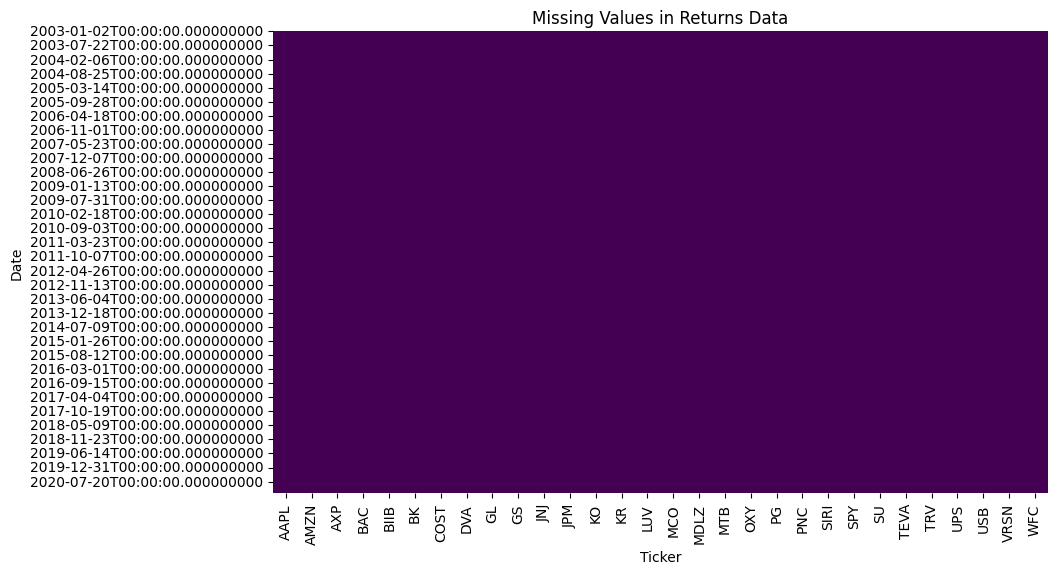

In [12]:
plot_missing_values(returns_all, "Missing Values in Returns Data")

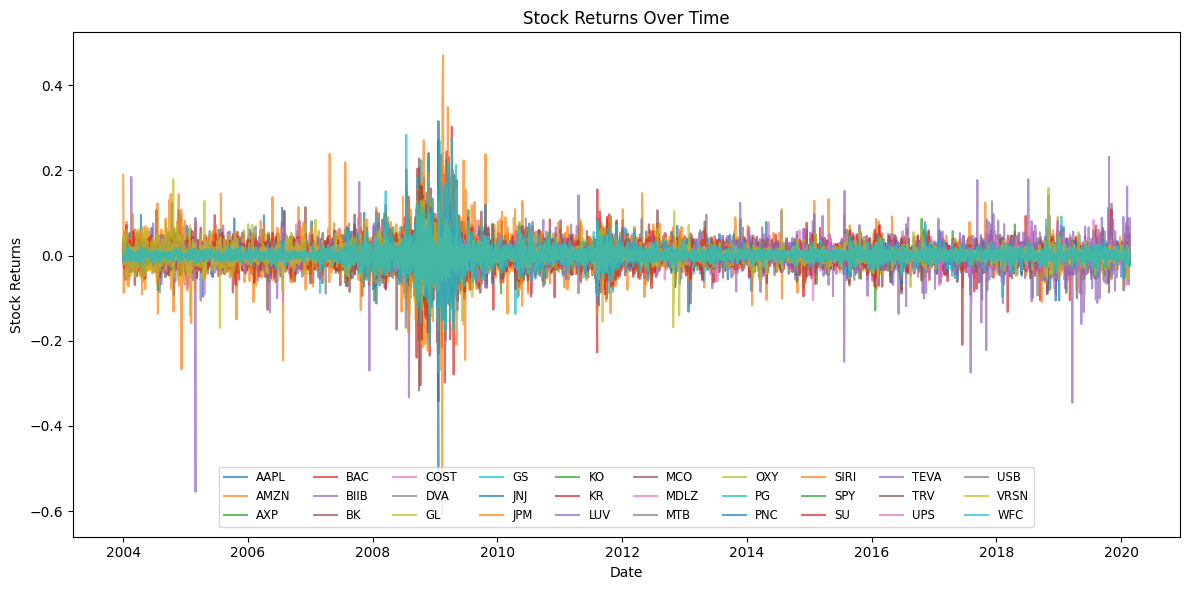

In [13]:
plot_stock_returns(returns_train)

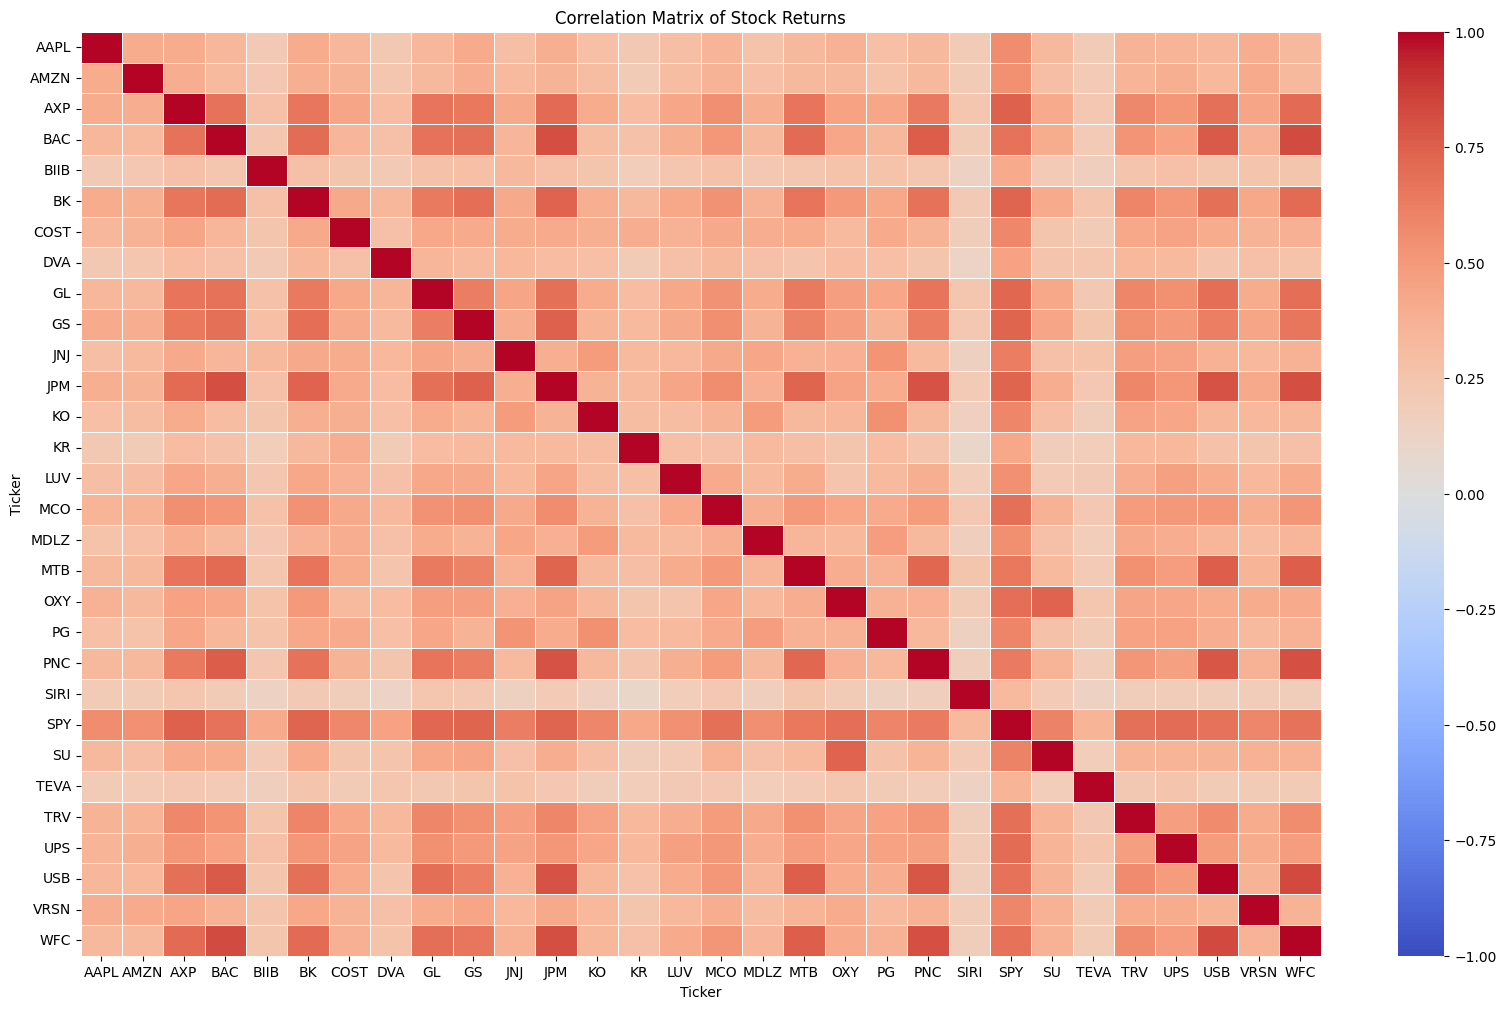

In [14]:
plot_correlation_matrix(
    returns_train, "Correlation Matrix of Stock Returns", figsize=(20, 12), annot=False
)

<a id="section_4_4"></a>
### Download and Prepare Macroeconomic Indicators

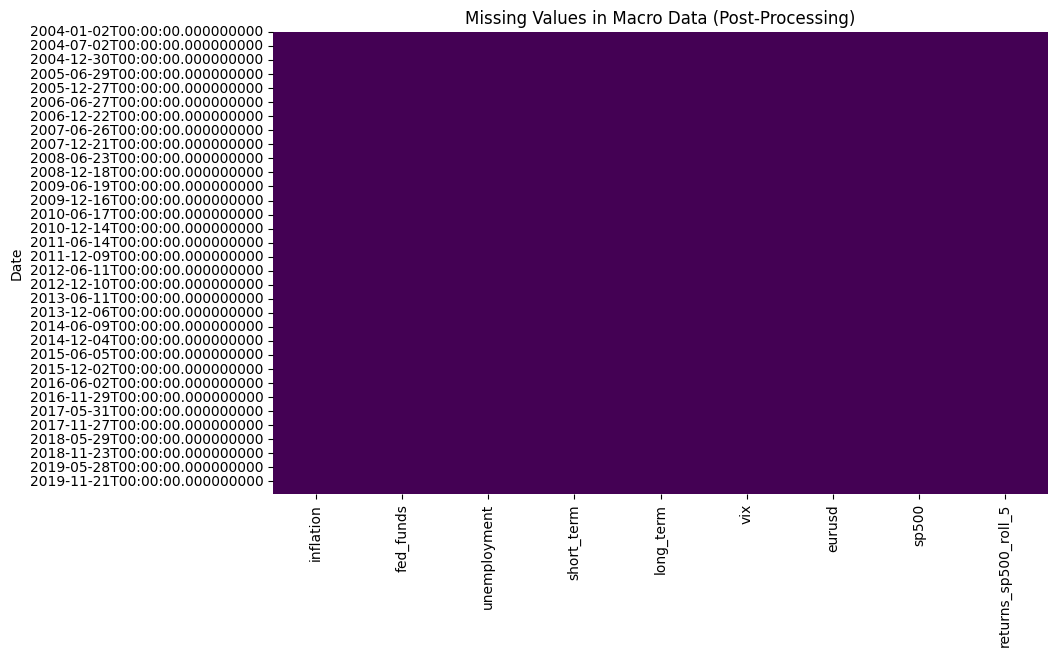

In [15]:
# Load FRED API Key
with open("key_fred.txt", "r") as file:
    fred_api_key = file.read().strip()

# Download FRED series
fred_data = download_fred_data(fred_api_key, pre_start_date, end_date)
vix_data, fx_data, sp500_data = download_other_data(pre_start_date, end_date)

macro_df = preprocess_macro_data(
    fred_data, vix_data, fx_data, sp500_data, start_date, backtest_end, returns_all.index
)

In [16]:
macro_df.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  
Date                                                             
2004-01-02  18.309999  1.259002  0.002053             -0.003099  
2004-01-05  18.219999  1.258194 -0.003099              0.000000  
2004-01-06  17.490000  1.268698  0.012319             -0.000321  
2004-01-07  16.730000  1.272103  0.001291             -0.001612  
2004-01-08  15.500000  1.264095  0.002364             -0.004547

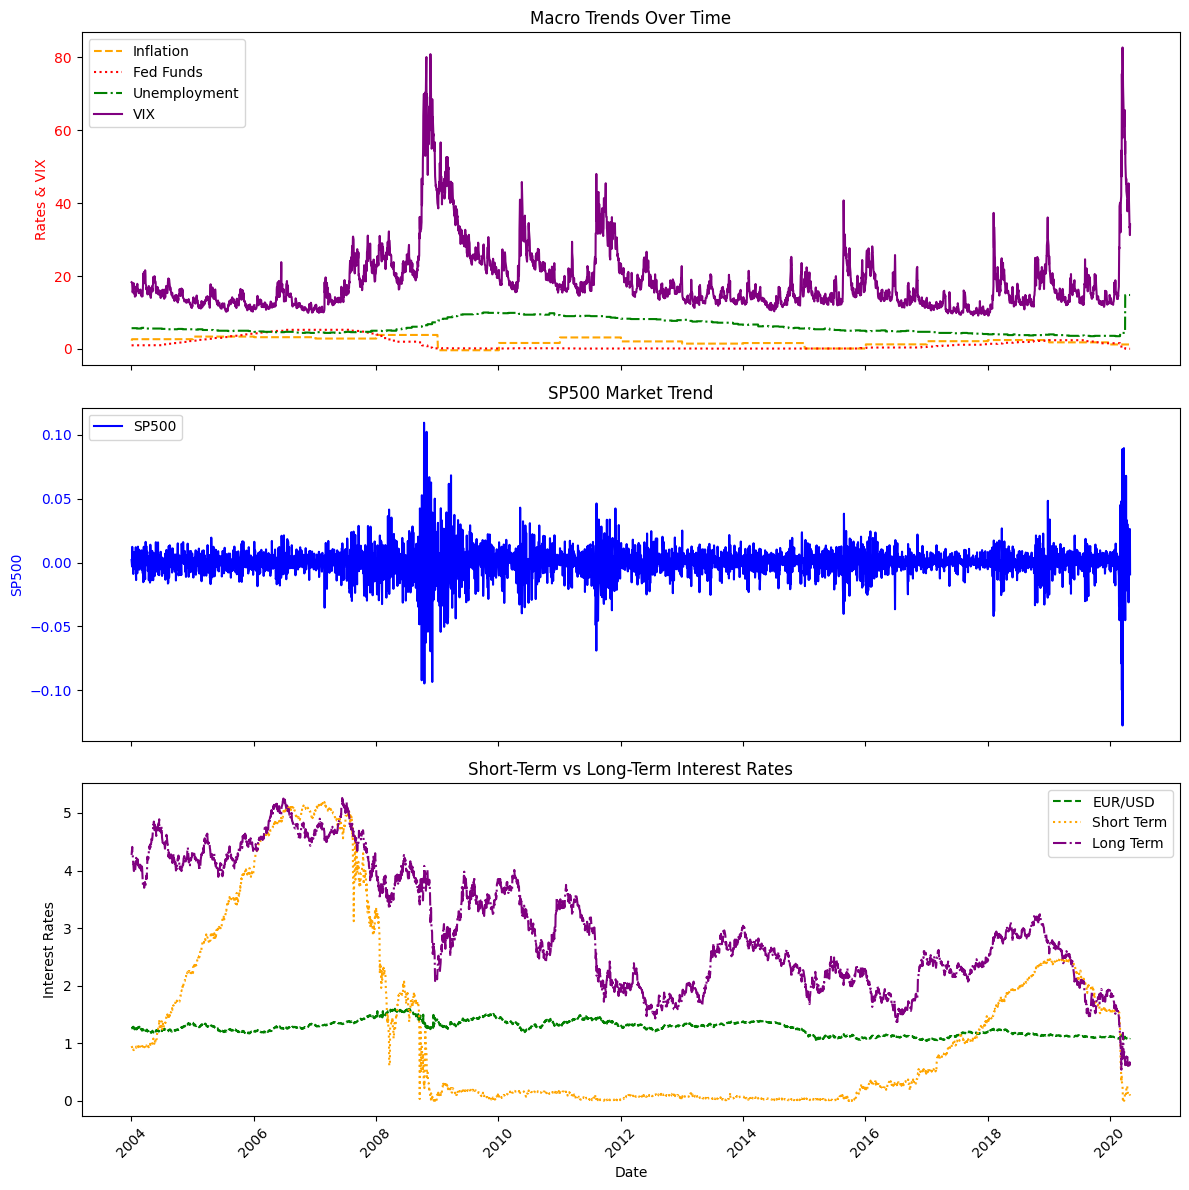

In [17]:
plot_macro_trend(macro_df)

<a id="section_4_5"></a>
### Prepare Input Features

In [18]:
input_features = process_input_features(
    macro_df,
    returns_all,
    market_data,
    start_date,
    end_date,
    portfolio_weights,
)

input_features.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  \
Date                                                              
2004-01-02  18.309999  1.259002  0.002053             -0.003099   
2004-01-05  18.219999  1.258194 -0.003099              0.000000   
2004-01-06  17.490000  1.268698  0.012319             -0.000321   
2004-01-07  16.730000  1.272103  0.001291             -0.001612   
2004-01-08  15.500000  1.264095  0.002364             -0.004547   

            portfolio_volatility  portfolio_volume  
Date                                                
2004-01-02              0.011617      7.338336e+07  
2004-01-05              0.012135      1.742616e+08  
2004-01-06              0.012069      1.974032e+08  
2004-01-07              0.012103      2.344443e+08  
2004-01-08              0.010964      1.942956e+08

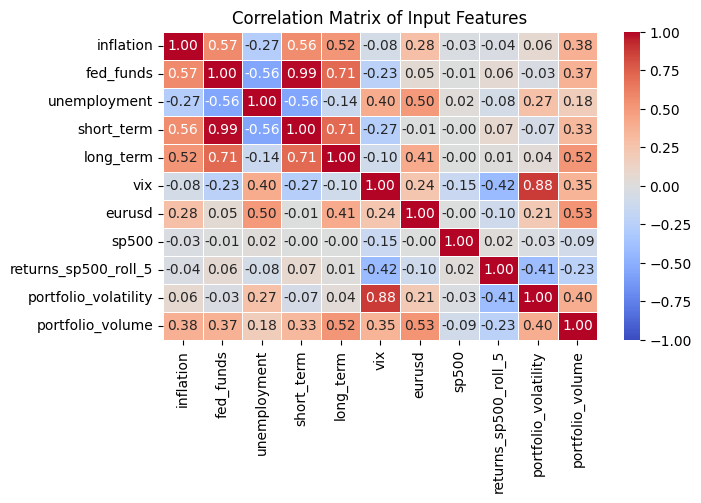

In [19]:
plot_correlation_matrix(input_features, "Correlation Matrix of Input Features")

In [20]:
print(f"#Nan in Input Features : {input_features.isna().sum().sum()}")

#Nan in Input Features : 0


In [21]:
input_train = input_features.loc[start_date:backtest_start]
input_test = input_features.loc[backtest_start:backtest_end]

# Scale input_features indicators
input_scaler = StandardScaler()
input_train_scaled = input_scaler.fit_transform(input_train)
input_test_scaled = input_scaler.transform(input_test)

<a id="section_5"></a>

## Model Implementation

<a id="section_5_1"></a>
### Define Custom Layers

In [22]:
from custom_libraries.custome_layer import (
    KLDivergenceLayer,
    SamplingLayer,
    ReconstructionLossLayer,
)

# Define the missing custom layer
custom_objects = {
    "KLDivergenceLayer": KLDivergenceLayer,
    "ReconstructionLossLayer": ReconstructionLossLayer,
    "SamplingLayer": SamplingLayer,
}

<a id="section_5_2"></a>
### Conditional Variational Autoencoder (cVAE)

In [23]:
from custom_libraries.custom_vae import (
    build_conditional_vae,
)

<a id="section_5_2"></a>
### Conditional Wasserstein GAN (WGAN-GP)

In [24]:
from custom_libraries.custom_wgangp import (
    build_conditional_generator,
    build_conditional_critic,
    train_conditional_wgan_gp,
)

<a id="section_6"></a>
## Model Training

<a id="section_6_1"></a>
### Training Parameters

In [25]:
n_samples = min(returns_train_scaled.shape[0], input_train_scaled.shape[0])
returns_scaled = returns_train_scaled[:n_samples]
macro_train_scaled = input_train_scaled[:n_samples]

In [25]:
return_dim = returns_scaled.shape[1]
input_dim = input_train_scaled.shape[1]
latent_dim = LATENT_DIM
noise_dim = NOISE_DIM

print(f"Returns dim: {return_dim}")
print(f"Input dim: {input_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Noise dim: {noise_dim}")

Returns dim: 30
Input dim: 11
Latent dim: 8
Noise dim: 10


<a id="section_6_2"></a>
### Train Conditional VAE

In [26]:
if not LOAD_MODEL:
    print("Training Conditional VAE...")
    encoder, decoder, cvae, early_stop = build_conditional_vae(
        return_dim, input_dim, intermediate_dim=256, latent_dim=latent_dim
    )

    cvae.fit(
        [returns_scaled, input_train_scaled],
        epochs=EPOCHS_CVAE,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )
    z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...


I0000 00:00:1741821446.622410  101975 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Epoch 1/500


2025-03-12 19:17:28.005700: I external/local_xla/xla/service/service.cc:152] XLA service 0x7fa47000db20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-12 19:17:28.005711: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-12 19:17:28.031970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741821448.161565  102186 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-12 19:17:29.455621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 40 bytes spill stores, 40 bytes spill loads

2025-03-12 19:17:30.023991: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spille

 71/115 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 2.2468

I0000 00:00:1741821451.968414  102186 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-12 19:17:33.680511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123', 4 bytes spill stores, 4 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.1641 

2025-03-12 19:17:36.281963: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-12 19:17:36.288261: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads

2025-03-12 19:17:37.281326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-12 19:17:37.474761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 8 bytes spill stores, 8 bytes spill loads

2025-03-12 19:17:37.823239: I external/local_xla/xla/stream_

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 2.1624 - val_loss: 1.4769
Epoch 2/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 1.5345 - val_loss: 1.2833
Epoch 3/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.4273 - val_loss: 1.3044
Epoch 4/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 1.3692 - val_loss: 1.2609
Epoch 5/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 1.3319 - val_loss: 1.2832
Epoch 6/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.3108 - val_loss: 1.2824
Epoch 7/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 1.2995 - val_loss: 1.3235
Epoch 8/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1.2862 - val_loss: 1.2659
Epoch 9/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 1.2841 - val_loss: 1.3038
Epoch 10/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.2525 - val_loss: 1.2869
Epoch 11/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 1.2405 - val_loss: 1.2895
Epoch 12/500
115/115 ━━━━━━━━━━

2025-03-12 19:17:40.839676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


<a id="section_6_3"></a>
### Train Conditional WGAN-GP

In [27]:
if not LOAD_MODEL:
    print("Training Conditional WGAN-GP...")
    generator = build_conditional_generator(noise_dim, input_dim, latent_dim)
    critic = build_conditional_critic(latent_dim, input_dim)
    generator, gen_losses, critic_losses, val_losses = train_conditional_wgan_gp(
        generator,
        critic,
        z_mean_train,
        input_train_scaled,
        input_test,
        noise_dim,
        epochs=EPOCHS_WGAN,
        important_index="returns_sp500_roll_5",
        patience=WGANGP_PATIENCE,
    )

Training Conditional WGAN-GP...


2025-03-12 19:17:57.308664: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Critic Loss = 9.2674, Gen Loss = -0.3289, Val Loss = -0.8879


2025-03-12 19:18:09.557516: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 19:18:33.437155: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 19:19:22.815020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10: Critic Loss = -0.7242, Gen Loss = 0.3179, Val Loss = 1.8823


2025-03-12 19:21:00.532579: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20: Critic Loss = -0.5486, Gen Loss = -0.7598, Val Loss = 0.4906
Epoch 30: Critic Loss = -0.4103, Gen Loss = -0.7270, Val Loss = -0.0167


2025-03-12 19:24:23.932130: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40: Critic Loss = -0.3848, Gen Loss = -0.1347, Val Loss = -0.1984
Epoch 50: Critic Loss = -0.3288, Gen Loss = -0.0513, Val Loss = -0.1027
Epoch 60: Critic Loss = -0.2667, Gen Loss = -0.0278, Val Loss = -0.1913


2025-03-12 19:30:53.040727: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70: Critic Loss = -0.2304, Gen Loss = 0.0320, Val Loss = -0.2049
Epoch 80: Critic Loss = -0.1847, Gen Loss = 0.0100, Val Loss = -0.2450
Epoch 90: Critic Loss = -0.1362, Gen Loss = -0.0670, Val Loss = -0.3312
Epoch 100: Critic Loss = -0.0969, Gen Loss = -0.1450, Val Loss = -0.3906
Epoch 110: Critic Loss = -0.0677, Gen Loss = -0.1597, Val Loss = -0.4342
Epoch 120: Critic Loss = -0.0425, Gen Loss = -0.1930, Val Loss = -0.4597


2025-03-12 19:44:12.660430: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130: Critic Loss = -0.0227, Gen Loss = -0.2289, Val Loss = -0.4885
Epoch 140: Critic Loss = -0.0040, Gen Loss = -0.2429, Val Loss = -0.5148
Epoch 150: Critic Loss = 0.0018, Gen Loss = -0.2456, Val Loss = -0.5218
Epoch 160: Critic Loss = 0.0106, Gen Loss = -0.2002, Val Loss = -0.5054
Epoch 170: Critic Loss = 0.0114, Gen Loss = -0.1743, Val Loss = -0.4630
Epoch 180: Critic Loss = 0.0165, Gen Loss = -0.1158, Val Loss = -0.4355
Epoch 190: Critic Loss = 0.0186, Gen Loss = -0.0632, Val Loss = -0.4035
Epoch 200: Critic Loss = 0.0248, Gen Loss = -0.0755, Val Loss = -0.4031
Epoch 210: Critic Loss = 0.0285, Gen Loss = -0.0754, Val Loss = -0.4180
Epoch 220: Critic Loss = 0.0281, Gen Loss = -0.1520, Val Loss = -0.4588
Epoch 230: Critic Loss = 0.0236, Gen Loss = -0.1562, Val Loss = -0.4617
Epoch 240: Critic Loss = 0.0256, Gen Loss = -0.2040, Val Loss = -0.5166
Epoch 250: Critic Loss = 0.0241, Gen Loss = -0.2282, Val Loss = -0.5375


2025-03-12 20:11:29.233351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 260: Critic Loss = 0.0217, Gen Loss = -0.2531, Val Loss = -0.5442
Epoch 270: Critic Loss = 0.0232, Gen Loss = -0.2422, Val Loss = -0.5505
Epoch 280: Critic Loss = 0.0211, Gen Loss = -0.2059, Val Loss = -0.5151
Epoch 290: Critic Loss = 0.0223, Gen Loss = -0.1669, Val Loss = -0.4402
Epoch 300: Critic Loss = 0.0238, Gen Loss = -0.2048, Val Loss = -0.4652
Epoch 310: Critic Loss = 0.0238, Gen Loss = -0.2098, Val Loss = -0.4481
Epoch 320: Critic Loss = 0.0242, Gen Loss = -0.1855, Val Loss = -0.4265
Epoch 330: Critic Loss = 0.0195, Gen Loss = -0.1747, Val Loss = -0.4106
Epoch 340: Critic Loss = 0.0230, Gen Loss = -0.1600, Val Loss = -0.4197
Epoch 350: Critic Loss = 0.0188, Gen Loss = -0.1696, Val Loss = -0.4141
Epoch 360: Critic Loss = 0.0235, Gen Loss = -0.1954, Val Loss = -0.4341
Epoch 370: Critic Loss = 0.0209, Gen Loss = -0.1994, Val Loss = -0.4114
Epoch 380: Critic Loss = 0.0180, Gen Loss = -0.1899, Val Loss = -0.4283
Epoch 390: Critic Loss = 0.0192, Gen Loss = -0.1465, Val Loss = 

<a id="section_6_4"></a>
### Plot Training Losses

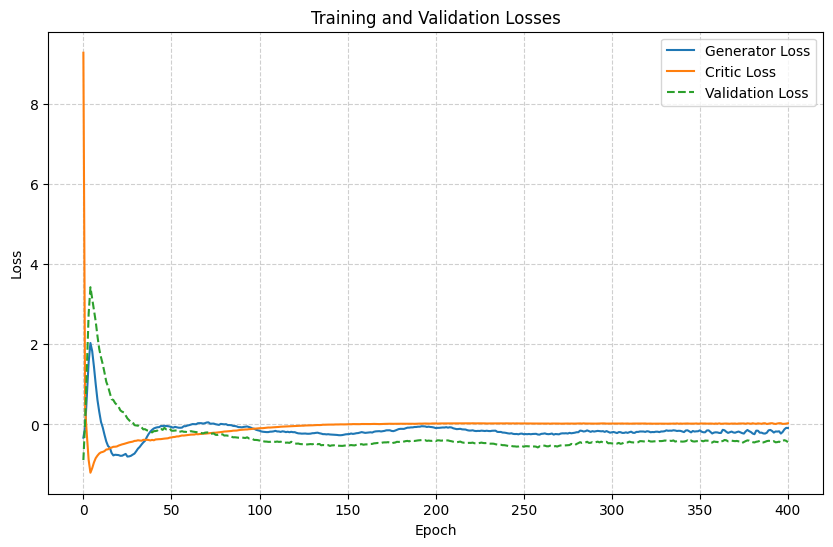

In [28]:
if not LOAD_MODEL:
    plot_gan_losses(gen_losses, critic_losses, val_losses)

<a id="section_6_5"></a>
### Save & Load Models

In [29]:
if LOAD_MODEL:
    encoder, decoder, cvae, generator, critic = load_models(
        custom_objects, FOLDER_MODELS
    )
    print("Load models")
else:
    save_models(encoder, decoder, cvae, generator, critic, FOLDER_MODELS)
    print("Save models")

Save models


<a id="section_7"></a>

## Scenario Generation and Stress Testing

<a id="section_7_1"></a>
### Feature Sensitivity Analysis

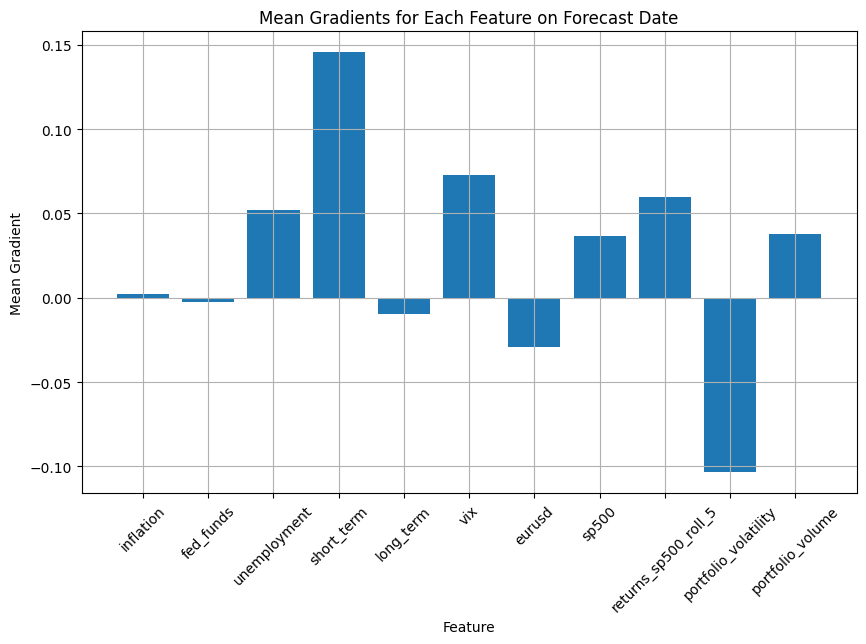

In [27]:
plot_mean_grad_features(input_test, generator)

<a id="section_7_2"></a>
### Backtesting Scenario Creation

In [28]:
input_test.describe()

inflation  fed_funds  unemployment  short_term  long_term        vix  \
count  51.000000  51.000000     51.000000   51.000000  51.000000  51.000000   
mean    1.233584   0.548824      8.541176    0.420196   0.861961  46.028824   
std     0.000000   0.528339      5.297591    0.523242   0.273511  15.901561   
min     1.233584   0.050000      3.500000    0.000000   0.540000  14.380000   
25%     1.233584   0.050000      4.400000    0.105000   0.635000  36.375000   
50%     1.233584   0.650000      4.400000    0.140000   0.760000  41.980000   
75%     1.233584   0.650000     14.800000    0.445000   1.020000  57.070002   
max     1.233584   1.580000     14.800000    1.580000   1.560000  82.690002   

          eurusd      sp500  returns_sp500_roll_5  portfolio_volatility  \
count  51.000000  51.000000             51.000000             51.000000   
mean    1.095674  -0.002863             -0.047158              0.040343   
std     0.017598   0.043055              0.049729              0.015246   
min     1.065735  -0.127652             -0.188892              0.009549   
25%     1.083072  -0.030240             -0.076627              0.029237   
50%     1.088957  -0.003823             -0.031155              0.048091   
75%     1.104979   0.024454             -0.001072              0.053501   
max     1.139796   0.089683              0.000000              0.056147   

       portfolio_volume  
count      5.100000e+01  
mean       1.105985e+08  
std        3.816572e+07  
min        4.950988e+07  
25%        8.053516e+07  
50%        1.028735e+08  
75%        1.413045e+08  
max        1.974422e+08

In [29]:
stress_values = {
    "returns_sp500_roll_5": -0.2,
}


<a id="section_7_3"></a>
### Rolling Backtesting

In [30]:
backtest_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
)

2025-03-12 23:36:59.651301: I external/local_xla/xla/service/service.cc:152] XLA service 0x794bc4004340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-12 23:36:59.651313: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-12 23:36:59.654514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741837019.662287  147759 cuda_dnn.cc:529] Loaded cuDNN version 90800


2025-03-12 23:37:00.150802: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 4 bytes spill stores, 4 bytes spill loads



227/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step

I0000 00:00:1741837020.616324  147759 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
313/313 ━━━━━

In [31]:
print("Rolling backtest results:")
backtest_df.head()

Rolling backtest results:


forecast_date  hist_portfolio_return  synthetic_VaR  synthetic_ES
0    2020-02-20              -0.006224      -0.103708     -0.104420
1    2020-02-21              -0.016266      -0.102477     -0.103310
2    2020-02-24              -0.042082      -0.101925     -0.102896
3    2020-02-25              -0.032877      -0.096419     -0.097605
4    2020-02-26               0.001837      -0.096193     -0.097364

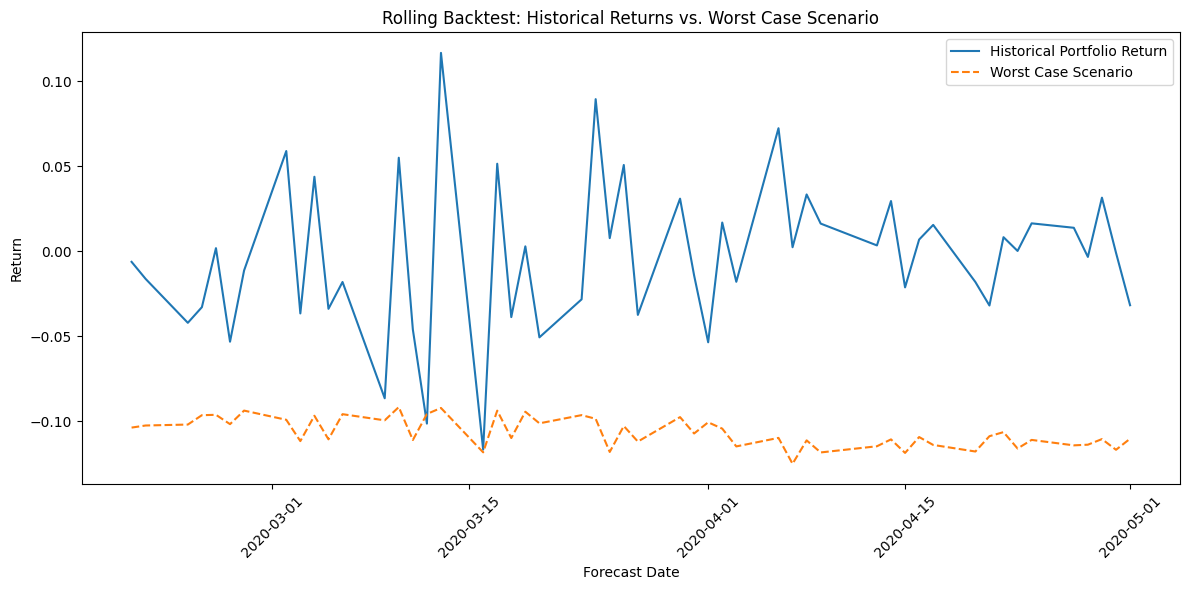

In [32]:
plot_historical_vs_synthetic_var_period(backtest_df)

<a id="section_7_4"></a>
### Backtesting Analysis by Stock

In [35]:
backtest_tickers_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
    by_ticker=True,
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
313/313 ━━━

In [36]:
print("Rolling backtest results:")
backtest_tickers_df.head()

Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022895         -0.026892        -0.012377   
2    2020-02-24         -0.048666         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001961          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051728         -0.005753       -0.036359         -0.028297   
4        -0.014585          0.010252       -0.005304          0.002686   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.083645          -0.142707   
1        -0.006638       -0.009218  ...         -0.082203          -0.143103   
2        -0.014735       -0.032012  ...         -0.082343          -0.143257   
3        -0.022086       -0.034235  ...         -0.075423          -0.142826   
4        -0.000123       -0.022963  ...         -0.075222          -0.142650   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.065309        -0.128634          -0.100339         -0.069909   
1         -0.063872        -0.128692          -0.099199         -0.068484   
2         -0.063042        -0.129058          -0.098044         -0.068134   
3         -0.057050        -0.123709          -0.091758         -0.061132   
4         -0.056632        -0.122821          -0.090596         -0.060743   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.067167         -0.098722          -0.130922         -0.093548  
1         -0.066907         -0.097763          -0.128986         -0.092043  
2         -0.066619         -0.096990          -0.127076         -0.092041  
3         -0.064500         -0.091865          -0.120165         -0.086995  
4         -0.064280         -0.092270          -0.119578         -0.087404  

[5 rows x 91 columns]

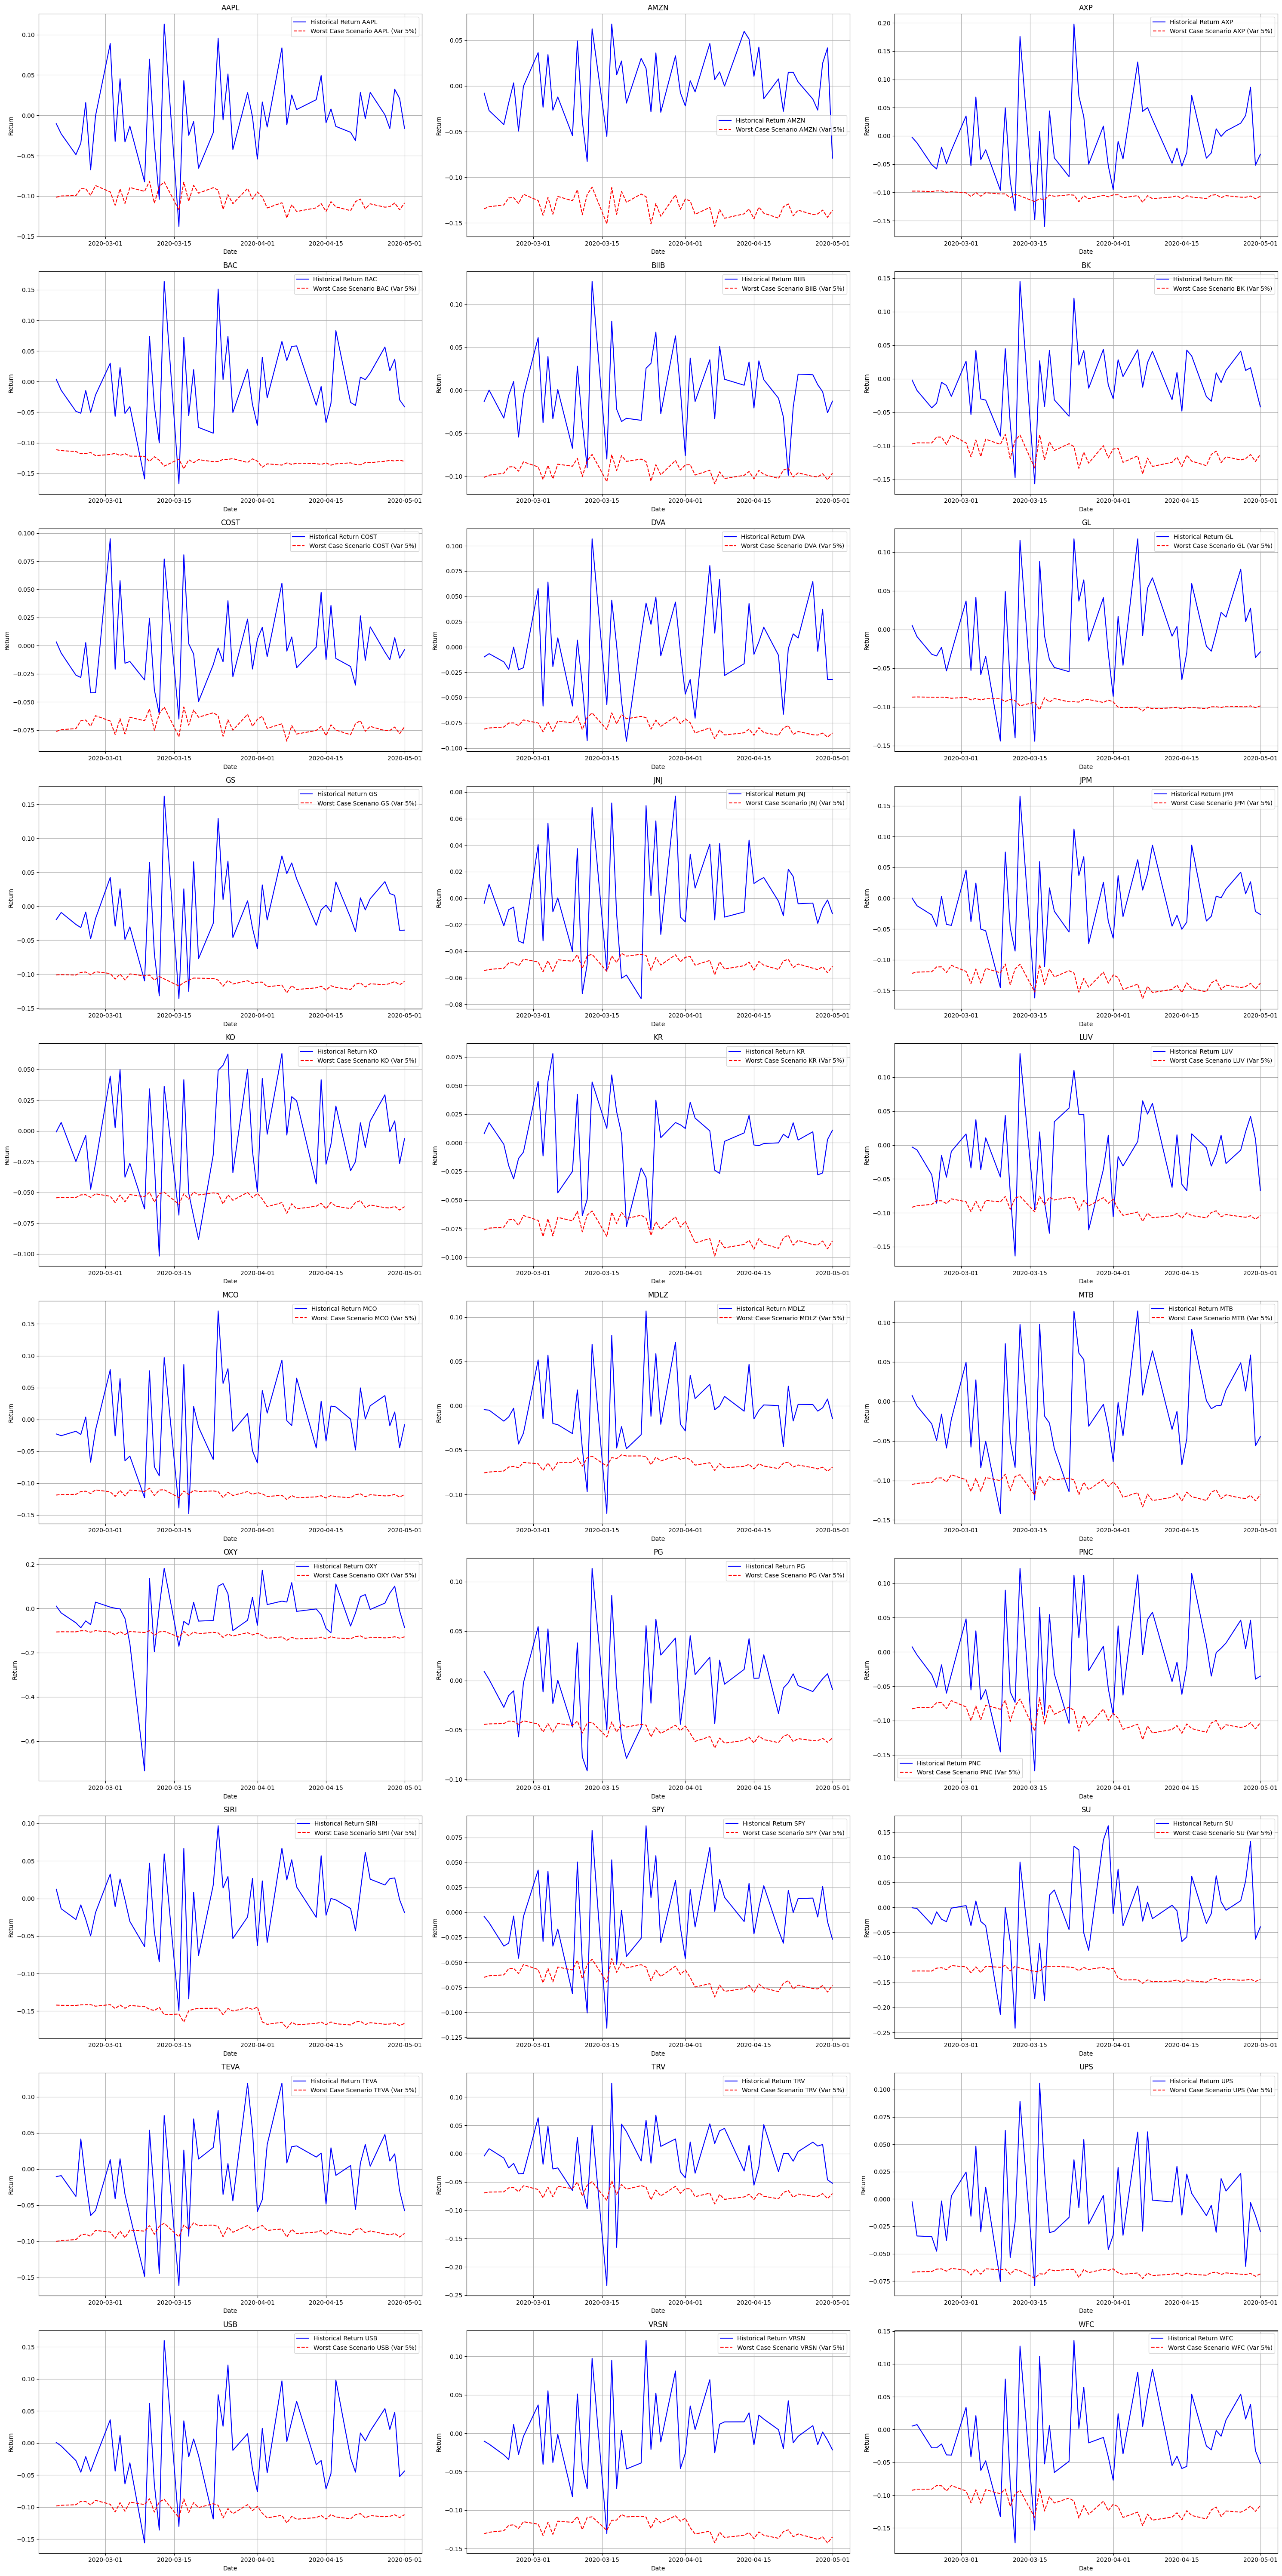

In [37]:
plot_historical_vs_synthetic_var_period_per_tickers(backtest_tickers_df, returns_test)

In [38]:
tickers_list = returns_test.columns.tolist()

hist_returns, synthetic_vars = backtest_tickers_ret_syn(
    tickers_list, backtest_tickers_df
)

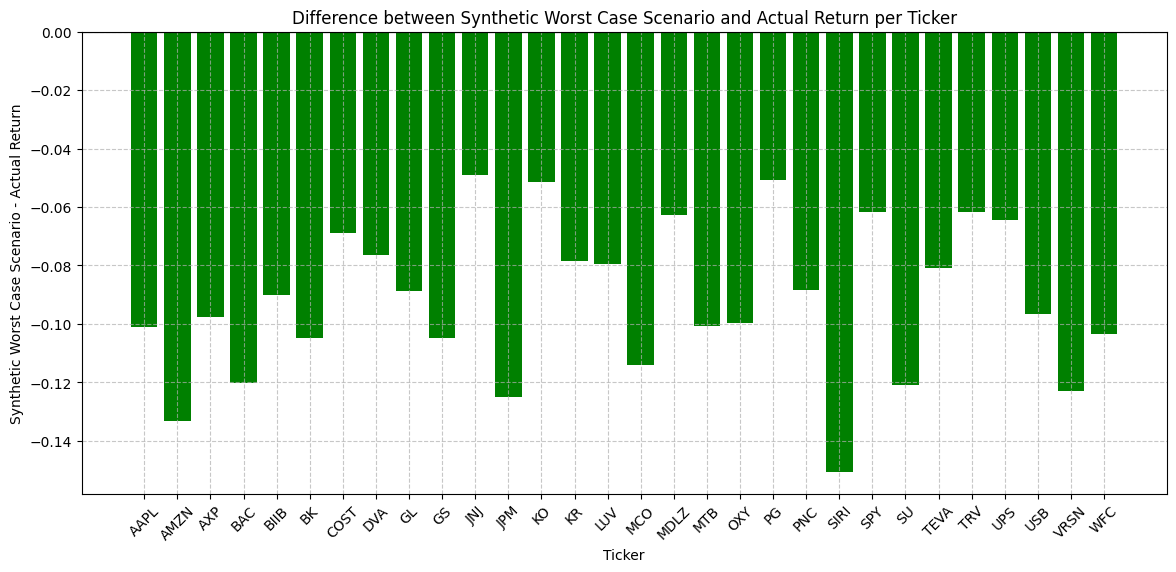

In [39]:
plot_bar_diff(hist_returns, synthetic_vars, tickers_list)

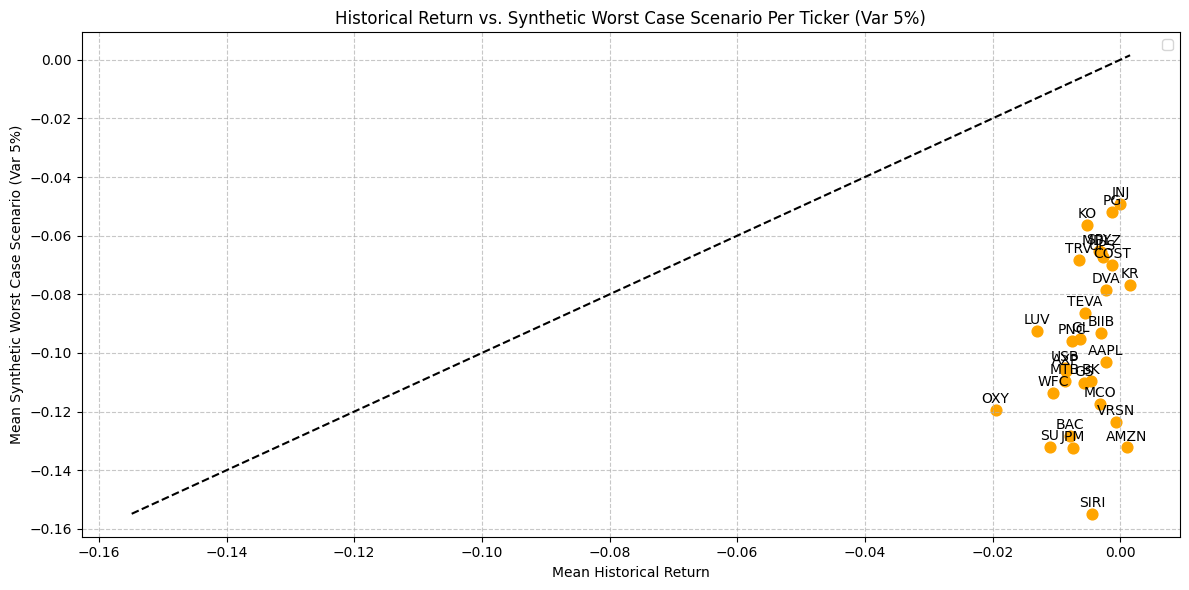

In [40]:
plot_scatter_actual_vs_synthetic_oblique(hist_returns, synthetic_vars, tickers_list)

2025-03-12 23:37:36.042180: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:37 776ms/step

2025-03-12 23:37:36.892439: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step  


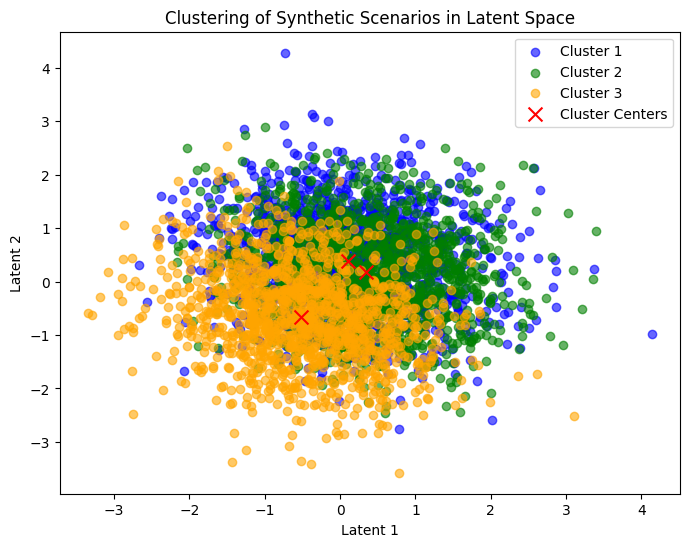

In [41]:
plot_latent_space_clustering(encoder, returns_train_scaled, SEED_RANDOM)

<a id="section_7_5"></a>
### Daily Backtesting

In [42]:
synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d = (
    detailed_evaluation_forecast(
        returns_test,
        input_test_scaled,
        generator,
        decoder,
        returns_scaler,
        NUM_SCENARIOS,
        NOISE_DIM,
        portfolio_weights,
        index_date=0,
    )
)

Forecast date: 2020-02-20 00:00:00
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
Detailed evaluation for forecast date: 2020-02-20 00:00:00
Synthetic Portfolio Returns - Summary:
count    10000.000000
mean        -0.037440
std          0.001101
min         -0.040187
25%         -0.038470
50%         -0.037590
75%         -0.036285
max         -0.035377
dtype: float64
Synthetic VaR (5th percentile): -0.0389
Synthetic ES: -0.0391


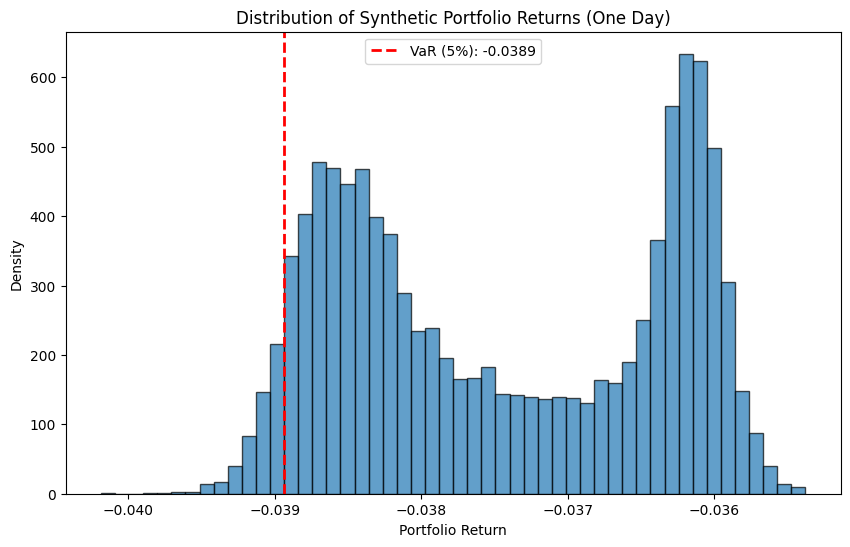

In [43]:
plot_distribution_synthetic_portfolio(synthetic_portfolio_returns_d, var_synth_d)

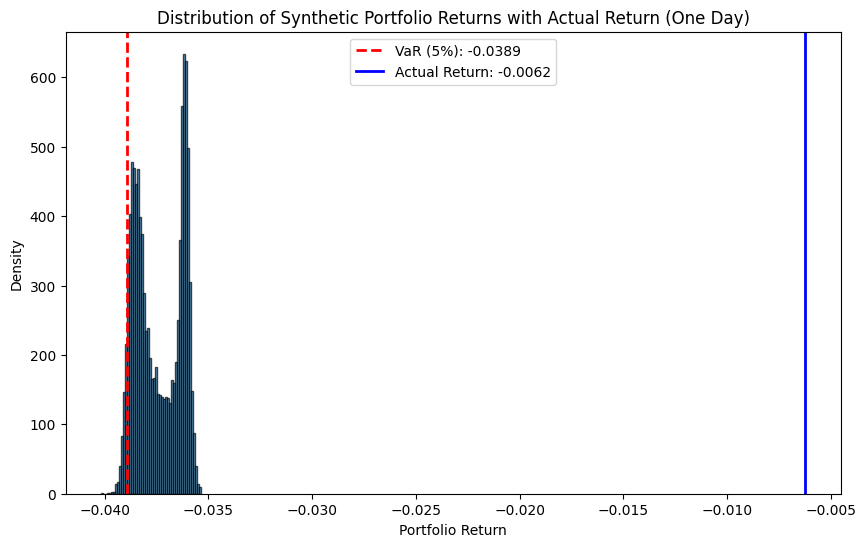

In [44]:
plot_distribution_synthetic_portfolio(
    synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d
)